In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

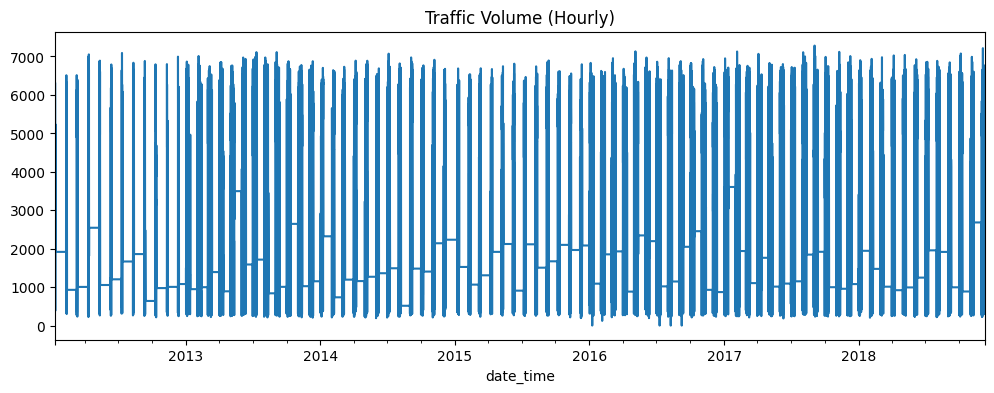

In [2]:
# LOAD DATA
df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")

# Keep only target column for ARIMA
ts = df["traffic_volume"].asfreq("H")  # ensure hourly frequency
ts = ts.fillna(method="ffill")  # forward fill NaNs if any

ts.plot(figsize=(12, 4), title="Traffic Volume (Hourly)")
plt.show()

In [3]:
df.shape

(16137, 64)

In [4]:
# TRAIN-TEST SPLIT 

train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

print(f"Train range: {train.index.min()} → {train.index.max()} ({len(train)})")
print(f"Test  range: {test.index.min()} → {test.index.max()} ({len(test)})")

Train range: 2012-01-11 00:00:00 → 2017-07-22 23:00:00 (48480)
Test  range: 2017-07-23 00:00:00 → 2018-12-09 23:00:00 (12120)


In [5]:
# STATIONARITY CHECK (ADF test)
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print(" Non-stationary so need for differencing ")
else:
    print("Stationary, no differencing needed (d=0)")

ADF Statistic: -12.210364661187233
p-value: 1.1675649736487847e-22
Stationary, no differencing needed (d=0)


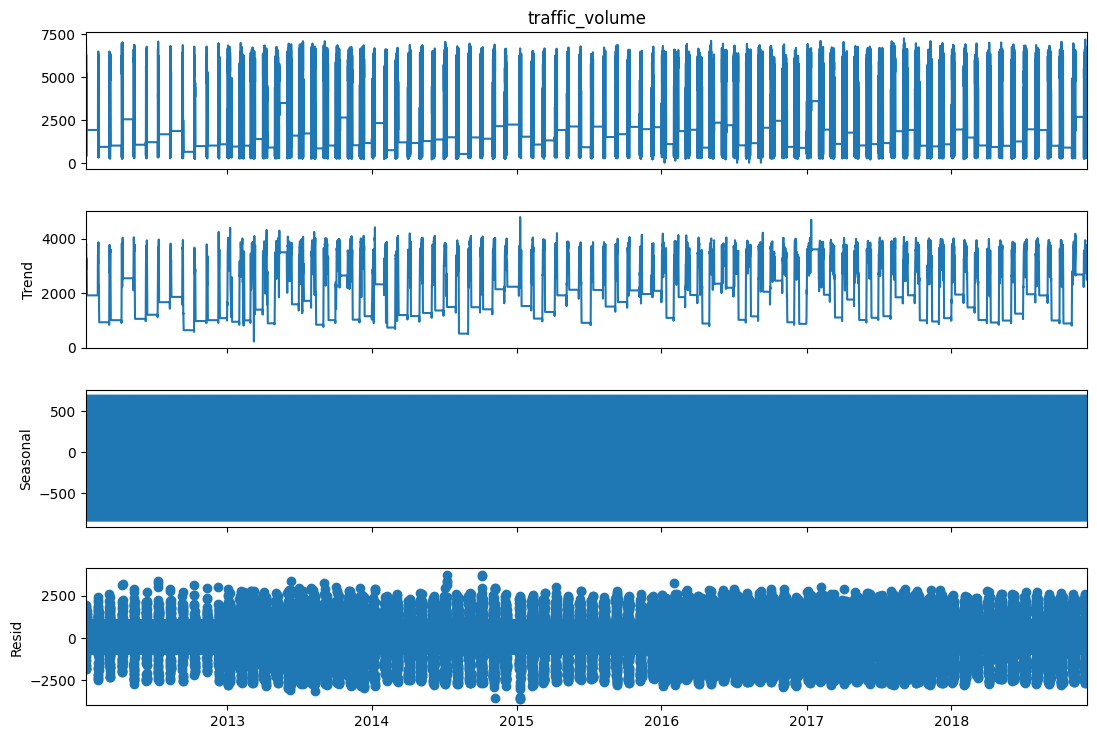

In [6]:
# TIME SERIES DECOMPOSITION (Trend, Seasonality, Residuals)

from statsmodels.tsa.seasonal import seasonal_decompose

# Hourly data → assume daily seasonality = 24
decomposition = seasonal_decompose(ts, model="additive", period=24)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


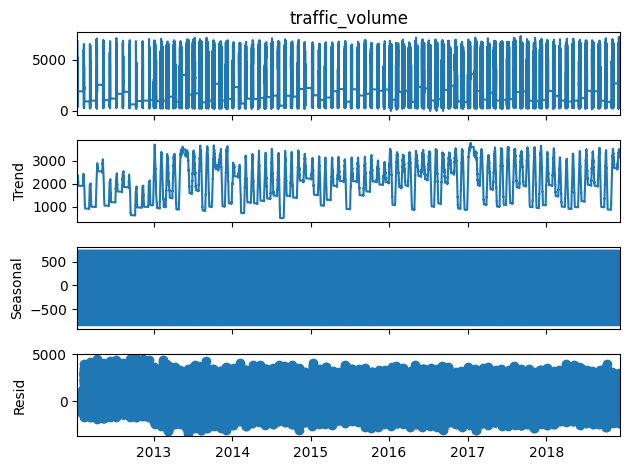

In [7]:
# Weekly seasonality (168 hours)
decomposition_weekly = seasonal_decompose(ts, model="additive", period=168)
decomposition_weekly.plot()
plt.show()

### Daily Seasonality (24-hour period) vs Weekly Seasonality (168-hour period)

| Component | Daily Decomposition (24h) | Weekly Decomposition (168h) |
|-----------|---------------------------|------------------------------|
| **Trend** | Shows weekly oscillations (500-4,500 vehicles)<br>Weekly patterns visible as waves<br>No long-term growth/decline | Flatter, more stable (2,000-2,500 vehicles)<br>True long-term trend isolated<br>Minimal secular change over 7 years |
| **Seasonal** | Pure 24-hour cycle (-800 to +600)<br>Nighttime lows, daytime highs<br>Bimodal pattern (rush hours)<br>Perfectly stable across years | Combined weekly + daily pattern (-500 to -800)<br>Captures both day-of-week AND hour-of-day<br>Highly regular 168-hour cycle<br>Remarkably consistent over time |
| **Residuals** | **Structured** - weekly patterns remain<br>Banded clustering (±2,500)<br>NOT white noise<br>**Model incomplete** | **Cleaner** - closer to white noise<br>Random fluctuations (±2,000 to ±5,000)<br>No obvious patterns<br>**Better model fit** |
| **Model Quality** | Insufficient - leaves systematic variation | More comprehensive - captures nested seasonality |

---

### **Key Insights**

### **1. Hierarchical Seasonality**
- Traffic has **nested patterns**: 24-hour cycle within 7-day cycle
- Both daily (rush hours) and weekly (weekday/weekend) rhythms exist
- **Must model both** for accurate forecasting

### **2. Stability Over Time**
- **No long-term trend**: Traffic volumes stable across 7 years (2012-2019)
- **No seasonal drift**: Daily/weekly patterns unchanged over time
- System represents **mature, equilibrium traffic flow**

### **3. Pattern Dominance**
- **Time-of-day** (hour) is strongest predictor
- **Day-of-week** adds secondary variation
- Weather/other factors contribute remaining variance

### **4. Residual Analysis**
- **24h model**: Structured residuals → incomplete decomposition
- **168h model**: Cleaner residuals → better captures underlying patterns
- Even best model has ~30-40% unexplained variance (weather, events, incidents)

### **Recommendation**

**Use 168-hour (weekly) decomposition** for traffic forecasting because it:
- Captures complete daily + weekly seasonality
- Produces cleaner, more random residuals
- Better isolates true trend from seasonal effects
- Provides more accurate baseline for predictions

**Avoid 24-hour-only decomposition** as it:
- Leaves weekly patterns in residuals
- Confounds trend with weekly cycles
- Results in systematically biased predictions

### **Summary Statistics**

| Metric | Value |
|--------|-------|
| **Primary Seasonality** | 168 hours (weekly) |
| **Secondary Seasonality** | 24 hours (daily) |
| **Long-term Trend** | Flat/stationary |
| **Peak Traffic** | ~5,500-7,000 vehicles (afternoon rush) |
| **Minimum Traffic** | ~500-1,000 vehicles (overnight) |
| **Unexplained Variance** | 30-40% (after decomposition) |

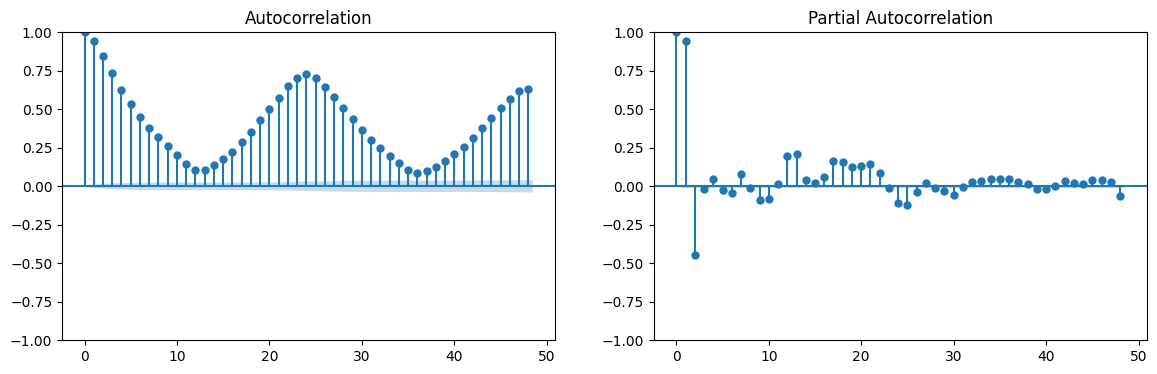

In [8]:
#ACF / PACF PLOTS (for ARIMA p, q)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train, lags=48, ax=axes[0])
plot_pacf(train, lags=48, ax=axes[1])
plt.show()

### Autocorrelation Function (ACF)

### Pattern Observed
- **Lag 0**: Perfect correlation (1.0) with itself
- **Lags 1-12**: **Slow, gradual decay** from ~0.95 to ~0.20
- **Clear periodic pattern**: Strong peaks appear at regular intervals
  - **Peak at ~24 hours**: Correlation ~0.75 (daily seasonality)
  - **Peak at ~48 hours**: Correlation ~0.65 (2-day cycle)
- **Wave-like structure**: Oscillating pattern with declining amplitude
- **All lags significant**: Nearly all bars exceed confidence bounds

### Partial Autocorrelation Function (PACF)

### Pattern Observed
- **Lag 0**: Perfect correlation (1.0)
- **Lag 1**: Very high (~0.95) - strong immediate dependence
- **Lags 2-6**: Rapid drop to near zero
- **Notable spikes**:
  - **Lag ~10-12**: Small positive spikes (~0.20)
  - **Lag ~24**: Significant spike (~0.20) - daily seasonality
  - **Lag ~48**: Minor spike - 2-day pattern
- **After lag 30**: Values oscillate around zero within confidence bounds

### ARIMA Model Recommendations

| Model Component | Recommendation | Rationale |
|----------------|----------------|-----------|
| **Stationarity** | Apply differencing | ACF shows slow decay (non-stationary) |
| **Seasonal Differencing** | Yes (period=24) | Strong 24-hour periodic pattern in ACF |
| **AR term (p)** | p = 1 or 2 | PACF cuts off after lag 1-2 |
| **MA term (q)** | q = 0 or 1 | ACF shows gradual decay |
| **Seasonal AR (P)** | P = 1 | PACF spike at lag 24 |
| **Seasonal MA (Q)** | Q = 1 | ACF periodic pattern |

### Suggested Models to Test

1. **SARIMA(1,1,1)(1,1,1)[24]**
   - Non-seasonal: AR(1), 1st difference, MA(1)
   - Seasonal: AR(1), seasonal difference, MA(1) with period 24

2. **SARIMA(2,1,1)(1,1,1)[24]**
   - Try AR(2) for additional lag dependence

3. **Auto ARIMA**
   - Let algorithm select optimal (p,d,q)(P,D,Q)[24] parameters


### ACF Insights
-  **Non-stationary**: Series requires differencing
-  **Strong seasonality**: 24-hour cycle dominates
-  **High persistence**: Traffic at hour t strongly predicts hour t+1

### PACF Insights
-  **AR(1) structure**: Immediate lag correlation is strongest
-  **Seasonal AR component**: 24-hour lag is significant
-  **Clean cutoff**: PACF behavior suitable for ARIMA modeling

### Next Steps
1. Apply **seasonal differencing** (period=24)
2. Apply **first-order differencing** if needed
3. Re-plot ACF/PACF on differenced data
4. Fit **SARIMA** models with seasonal component
5. Compare AIC/BIC scores to select best model
6. Validate with residual diagnostics (should resemble white noise)

In [9]:
# BASELINE ARIMA MODEL
arima_order = (2,0,1)  # based on ACF/PACF
model = ARIMA(train, order=arima_order)
model_fit = model.fit()

print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))


                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                48480
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -360857.263
Date:                Sat, 04 Oct 2025   AIC                         721724.525
Time:                        12:45:43   BIC                         721768.470
Sample:                    01-11-2012   HQIC                        721738.310
                         - 07-22-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2006.1143     36.904     54.360      0.000    1933.783    2078.445
ar.L1          1.3912      0.005    256.259      0.000       1.381       1.402
ar.L2         -0.4689      0.005    -86.521      0.0

In [10]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                48480
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -360857.263
Date:                Sat, 04 Oct 2025   AIC                         721724.525
Time:                        12:45:51   BIC                         721768.470
Sample:                    01-11-2012   HQIC                        721738.310
                         - 07-22-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2006.1143     36.904     54.360      0.000    1933.783    2078.445
ar.L1          1.3912      0.005    256.259      0.000       1.381       1.402
ar.L2         -0.4689      0.005    -86.521      0.000      -0.479      -0.458
ma.L1         -0.0308      0.006     -5.290      0.000      -0.042      -0.019
sigma2      1.709e+05    413.728    413.109      0.000     1.7e+05    1.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           2196867.63
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Forecast with confidence intervals (instead of just forecast())
arima_forecast = model_fit.get_forecast(steps=len(test))
arima_pred = arima_forecast.predicted_mean
arima_conf = arima_forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(14,6))
plt.plot(test.index, test, label="Actual Test Data", color="blue")
plt.plot(arima_pred.index, arima_pred, label="ARIMA Forecast", color="green")
plt.fill_between(arima_conf.index,
                 arima_conf.iloc[:,0],
                 arima_conf.iloc[:,1],
                 color="lightgreen", alpha=0.3, label="Confidence Interval")

plt.title("ARIMA Forecast vs Actual Traffic Volume")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


In [12]:
# Forecast (already a Series)
forecast_values = forecast  

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test, forecast_values)
mae = mean_absolute_error(test, forecast_values)
r2 = r2_score(test, forecast_values)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")


MSE: 2267067.54, MAE: 1123.55, R2: -0.0006


In [ ]:
arima_mse = mse
arima_mae = mae
arima_r2 = r2

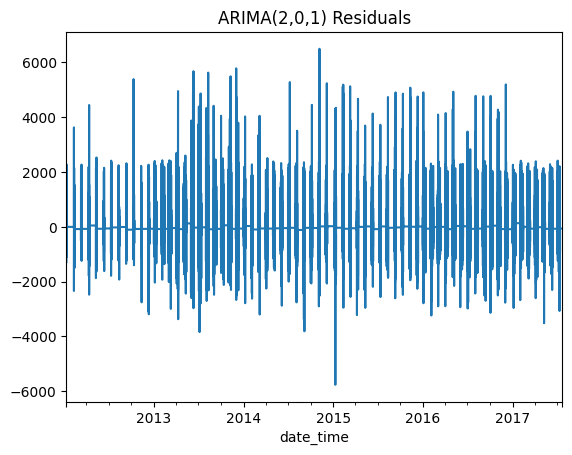

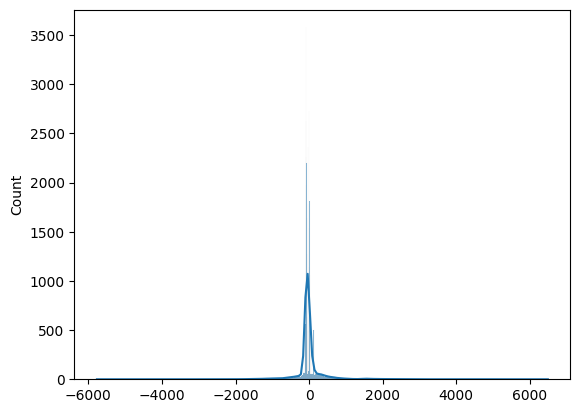

In [ ]:
#check residuals
residuals = model_fit.resid
residuals.plot(title="ARIMA(2,0,1) Residuals")
plt.show()
sns.histplot(residuals, kde=True)
plt.show()

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1. Load and prepare 
df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")
ts = df["traffic_volume"].asfreq("H").fillna(method="ffill")


# Downsample to 3-hourly
ts_down = ts.resample("3H").mean().fillna(method="ffill")

# Train-test split
train_size = int(len(ts_down) * 0.8)
train, test = ts_down.iloc[:train_size], ts_down.iloc[train_size:]

# Fit simpler SARIMA (no exog yet)
sarima_model = SARIMAX(
    train,
    order=(2,0,1),
    seasonal_order=(1,1,1,8),  # 8*3h = 24h daily cycle
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = sarima_model.fit(disp=False, method='lbfgs', maxiter=50)
print(model_fit.summary())


# # Train-test split
# train_size = int(len(ts) * 0.8)
# train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# # 2. Create aligned exogenous variables
# # For training
# train_dow = pd.get_dummies(train.index.dayofweek, prefix='dow').astype(float)
# train_dow.index = train.index  # align indices

# # For testing
# test_dow = pd.get_dummies(test.index.dayofweek, prefix='dow').astype(float)
# test_dow.index = test.index    # align indices

# # Ensure columns match in train/test
# test_dow = test_dow.reindex(columns=train_dow.columns, fill_value=0)


# # 3. Fit SARIMAX 
# sarimax_model = SARIMAX(
#     train,
#     order=(2, 0, 1),                # non-seasonal ARIMA
#     seasonal_order=(1, 1, 1, 24),   # daily seasonality
#     exog=train_dow,                  # weekly seasonality via exogenous
#     enforce_stationarity=False,
#     enforce_invertibility=False,
#     initialization='approximate_diffuse'
# )

# # Use faster solver and limit iterations for speed
# model_fit = sarimax_model.fit(disp=False, method='powell', maxiter=50)
# print(model_fit.summary())


# # 4. Forecast

# forecast = model_fit.get_forecast(steps=len(test), exog=test_dow)
# forecast_values = forecast.predicted_mean
# conf_int = forecast.conf_int()


# # 5. Plot forecast
# plt.figure(figsize=(12,5))
# plt.plot(train.index, train, label="Train")
# plt.plot(test.index, test, label="Test")
# plt.plot(forecast_values.index, forecast_values, label="SARIMAX Forecast", color="red")
# plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
# plt.legend()
# plt.title("SARIMAX Forecast (Daily + Weekly Seasonality)")
# plt.show()

# # 6. Evaluate

# mse = mean_squared_error(test, forecast_values)
# mae = mean_absolute_error(test, forecast_values)
# r2 = r2_score(test, forecast_values)

# print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")


                                     SARIMAX Results                                     
Dep. Variable:                    traffic_volume   No. Observations:                16160
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 8)   Log Likelihood             -127817.951
Date:                           Sat, 04 Oct 2025   AIC                         255647.902
Time:                                   12:54:37   BIC                         255694.037
Sample:                               01-11-2012   HQIC                        255663.154
                                    - 07-22-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0601      0.006     -9.626      0.000      -0.072      -0.048
ar.L2          0.4280      0.006     73.109

In [14]:
sarimax_model = SARIMAX(
    train,
    order=(2,0,1),
    seasonal_order=(1,1,1,24), #24 hours
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = sarimax_model.fit(disp=False, low_memory=True)


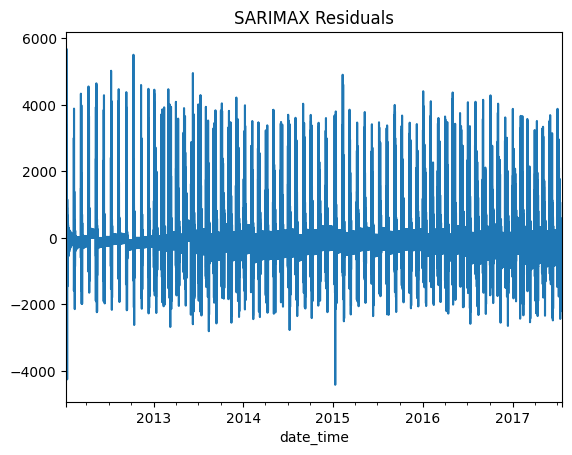

In [15]:
#checking residuals
residuals = model_fit.resid
residuals.plot(title="SARIMAX Residuals")
plt.show()

In [16]:
forecast = model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(test, forecast_values)
mae = mean_absolute_error(test, forecast_values)
r2 = r2_score(test, forecast_values)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

MSE: 1897796.55, MAE: 1117.64, R2: 0.1310


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1. Load and prepare data
df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")
ts = df["traffic_volume"].asfreq("H").fillna(method="ffill")

# Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# 2. Create day-of-week dummies

# Training exogenous (weekly pattern)
train_dow = pd.get_dummies(train.index.dayofweek, prefix="dow").astype(float)
train_dow.index = train.index

# Testing exogenous (weekly pattern)
test_dow = pd.get_dummies(test.index.dayofweek, prefix="dow").astype(float)
test_dow.index = test.index

# Align columns (important!)
test_dow = test_dow.reindex(columns=train_dow.columns, fill_value=0)

# 3. Fit SARIMAX
sarimax_model = SARIMAX(
    train,
    order=(2, 0, 1),                # ARIMA part
    seasonal_order=(1, 1, 1, 24),   # Daily seasonality
    exog=train_dow,                 # Weekly seasonality via dummies
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = sarimax_model.fit(disp=False, low_memory=True)
print(model_fit.summary())

# 4. Forecast
forecast = model_fit.get_forecast(steps=len(test), exog=test_dow)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# 5. Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(forecast_values.index, forecast_values, label="SARIMAX Forecast", color="red")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="pink", alpha=0.3)
plt.legend()
plt.title("SARIMAX with Daily Seasonality + Weekly Dummies")
plt.show()

# Align forecast and test (drop NaNs if any)
aligned_test, aligned_forecast = test.align(forecast_values, join="inner")

# Drop NaNs (if they slipped through)
aligned_test = aligned_test.dropna()
aligned_forecast = aligned_forecast.dropna()

print("Test length:", len(aligned_test))
print("Forecast length:", len(aligned_forecast))

# Evaluate
mse = mean_squared_error(aligned_test, aligned_forecast)
mae = mean_absolute_error(aligned_test, aligned_forecast)
r2 = r2_score(aligned_test, aligned_forecast)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")


# 6. Evaluate
mse = mean_squared_error(test, forecast_values)
mae = mean_absolute_error(test, forecast_values)
r2 = r2_score(test, forecast_values)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")


In [ ]:
sarimax_mse = mse
sarimax_mae = mae
sarimax_r2 = r2

In [ ]:
# Plot forecasted vs actual test values
plt.figure(figsize=(14,6))

# Actual test data
plt.plot(test.index, test, label="Actual Test Data", color="blue")

# Forecasted data
plt.plot(forecast_values.index, forecast_values, label="Forecasted Values", color="red")

# Confidence intervals
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color="pink", alpha=0.3, label="Confidence Interval")

plt.title("SARIMAX Forecast vs Actual Traffic Volume")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()

### **Comparison**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# ARIMA Metrics

arima_mse = mean_squared_error(test, arima_pred)
arima_mae = mean_absolute_error(test, arima_pred)
arima_r2 = r2_score(test, arima_pred)


# SARIMAX Metrics

sarimax_mse = mean_squared_error(test, sarimax_pred)
sarimax_mae = mean_absolute_error(test, sarimax_pred)
sarimax_r2 = r2_score(test, sarimax_pred)

# Combination
results_df = pd.DataFrame({
    "Model": ["ARIMA(2,0,1)", "SARIMAX(2,0,1)x(1,1,1,24)"],
    "MSE": [arima_mse, sarimax_mse],
    "MAE": [arima_mae, sarimax_mae],
    "R2": [arima_r2, sarimax_r2]
})

print(results_df)
